<a href="https://colab.research.google.com/github/melissaortegaa/monografia/blob/main/04_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

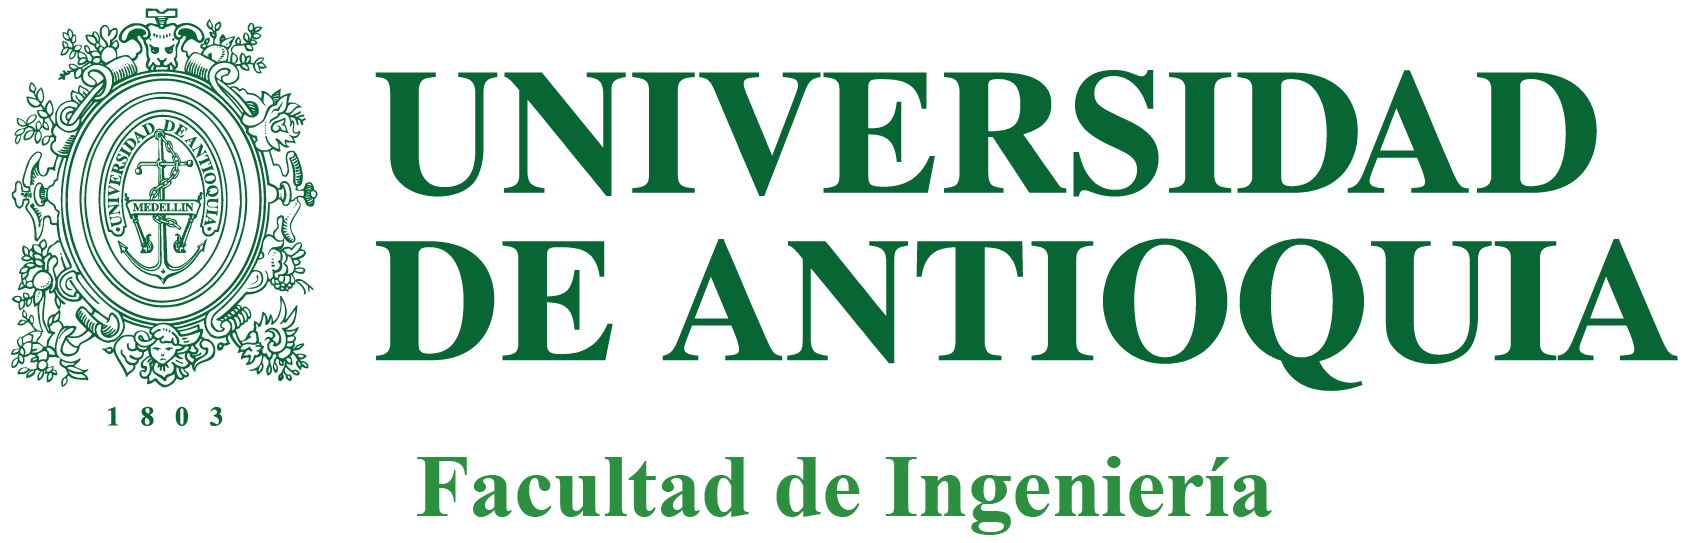
---

**Especialización en Analítica y Ciencia de Datos**

**Universidad de Antioquia**

**2024**

**Melissa Ortega Alzate**

---

## Imports & Settings

In [1]:
%matplotlib inline
import zipfile
import os
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Data manipulation and processing
import numpy as np
import pandas as pd

# Models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

# Callbacks and optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
results_path = Path('results', 'transfer_learning')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [4]:
sns.set_style('whitegrid')

## Load the dataset

In [5]:
# Download the preprocessed zip file from Google Drive
!gdown '1ZYWZY0GsHBKw67mk-0MLLZmow2At7VG0' -O \
   /tmp/data1.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ZYWZY0GsHBKw67mk-0MLLZmow2At7VG0
From (redirected): https://drive.google.com/uc?id=1ZYWZY0GsHBKw67mk-0MLLZmow2At7VG0&confirm=t&uuid=c880429e-49c4-4928-9002-f802df0c3124
To: /tmp/data1.zip
100% 172M/172M [00:01<00:00, 93.1MB/s]


In [6]:
# Extract the files
local_zip = '/tmp/data1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/data')
zip_ref.close()

In [7]:
# Define # Directories
base_dir = '/tmp/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Training directories
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_salmo_dir = os.path.join(train_dir, 'salmo')

# Validation directories
validation_healthy_dir = os.path.join(validation_dir, 'healthy')
validation_salmo_dir = os.path.join(validation_dir, 'salmo')

# Test directories
test_healthy_dir = os.path.join(test_dir, 'healthy')
test_salmo_dir = os.path.join(test_dir, 'salmo')

# Lists of files in folders
train_healthy_fnames = os.listdir(train_healthy_dir)
train_salmo_fnames = os.listdir(train_salmo_dir)
train_healthy_fnames = os.listdir(test_healthy_dir)
train_salmo_fnames = os.listdir(test_salmo_dir)
validation_healthy_fnames = os.listdir(validation_healthy_dir)
validation_salmo_fnames = os.listdir(validation_salmo_dir)

## Preprocessing: data augmentation and normalization

In [8]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
EPOCHS = 50          # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided (unless the steps_per_epoch flag is set to something other than None)
BATCH_SIZE = 32      # Number of samples per gradient update
STEPS_PER_EPOCH = 20 # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch
VALIDATION_STEPS = 10

In [9]:
# Transforms will be added to the images to increase the size of the datasets.
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, rescale=1./255,)
validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, rescale=1./255,)

# Flow training images in batches using train_datagen generator for categorical models.
train_generator_cat = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size = BATCH_SIZE,
        class_mode='categorical')

test_generator_cat = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size = BATCH_SIZE,
        class_mode='categorical',
        shuffle=False)

validation_generator_cat = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size = BATCH_SIZE,
        class_mode='categorical')

Found 4023 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [10]:
print(f"Train data examples for 1st class: \n{train_healthy_fnames[:10]}")
print(f"\nTrain data examples for 2nd class: \n{train_salmo_fnames[:10]}")

Train data examples for 1st class: 
['pcrhealthy.138.jpg', 'healthy.711.jpg', 'healthy.116.jpg', 'pcrhealthy.240.jpg', 'healthy.541.jpg', 'healthy.1223.jpg', 'healthy.389.jpg', 'healthy.1961.jpg', 'healthy.1671.jpg', 'healthy.1128.jpg']

Train data examples for 2nd class: 
['salmo.1883.jpg', 'salmo.1513.jpg', 'salmo.795.jpg', 'salmo.1332.jpg', 'salmo.2275.jpg', 'salmo.678.jpg', 'pcrsalmo.313.jpg', 'salmo.1008.jpg', 'salmo.491.jpg', 'salmo.1538.jpg']


## Load the VGG16 features

Using the VGG16 weights, pre-trained on ImageNet with the much smaller 32 x 32 CIFAR10 data. The the new input size upon import and set all layers to not trainable is defined:

In [11]:
# Create the base model from the pre-trained model VGG16 without top layers (until bottleneck)
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(IMG_SIZE, IMG_SIZE, 3),
                   )

58889256/58889256 [==============================] - 2s 0us/step


In [12]:
# Print and example of batch images
image_batch, label_batch = next(train_generator_cat)
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 7, 7, 512])

This feature extractor converts each 224x224x3 image into a 7x7x512 block of features.

## Freeze the convolutional base layers

In [13]:
# Freeze the convolutional base
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Add new layers to model

Using Keras’ functional API to define the vgg16 output as input into a new set of fully-connected layers like so:

In [14]:
# Adding top custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

Define a new model in terms of inputs and output, and proceed from there on as before:

In [15]:
transfer_model = Model(inputs = base_model.input,
                       outputs = predictions)

In [16]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

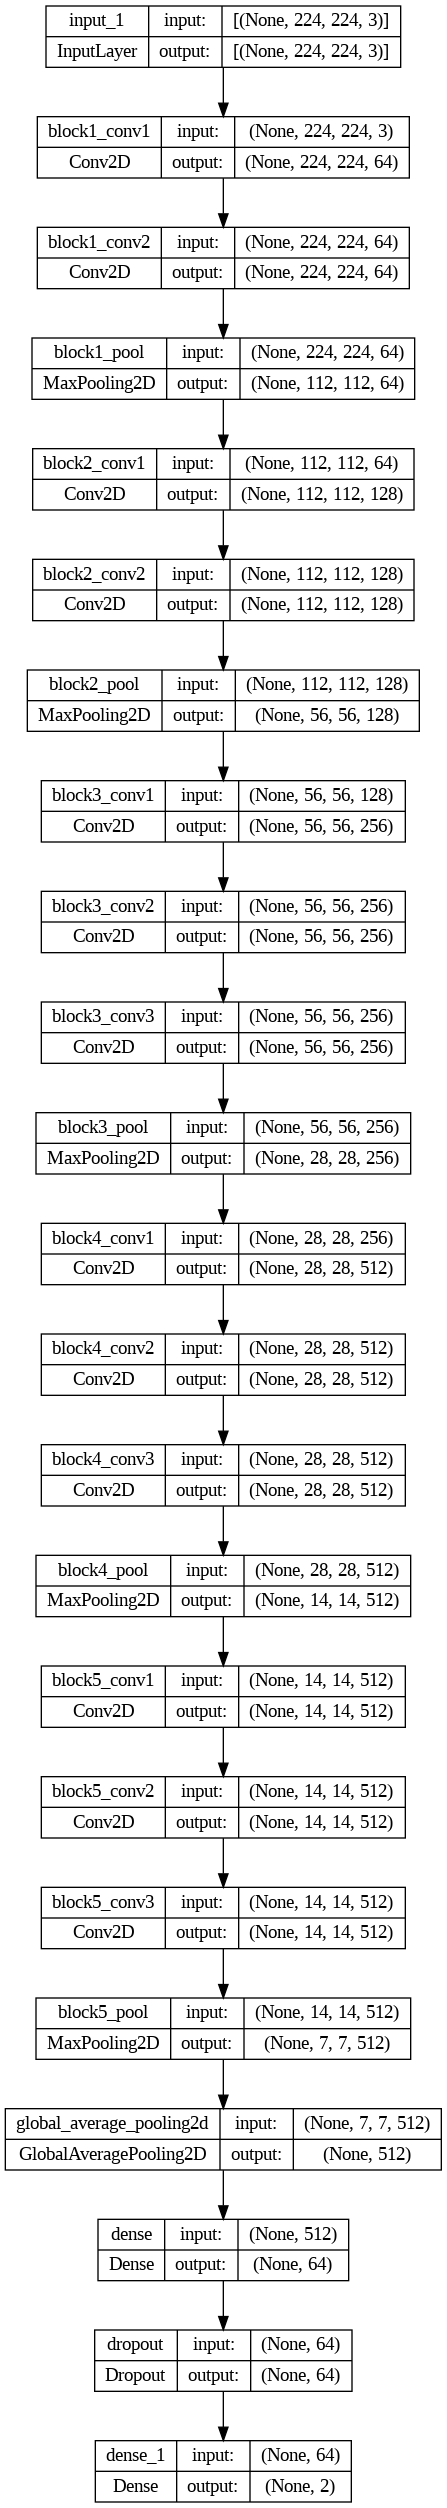

In [17]:
# Plot model
tf.keras.utils.plot_model(transfer_model, show_shapes=True)

In [18]:
transfer_model.compile(loss='categorical_crossentropy',
              optimizer = RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Compute baseline metrics

In [19]:
initial_epochs = 20
validation_steps=10

initial_loss, initial_accuracy = transfer_model.evaluate(validation_generator_cat)

8/8 [==============================] - 13s 922ms/step - loss: 1.7228 - accuracy: 0.4783


## Train VGG16 transfer model

In [20]:
history = transfer_model.fit(
                            train_generator_cat,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = initial_epochs,
                            validation_data = validation_generator_cat,
                            validation_steps = VALIDATION_STEPS,
                            verbose=1,
                            )

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.7756 - accuracy: 0.5469

20/20 [==============================] - 12s 481ms/step - loss: 0.7756 - accuracy: 0.5469 - val_loss: 0.5747 - val_accuracy: 0.7273
Epoch 2/20
20/20 [==============================] - 13s 630ms/step - loss: 0.5524 - accuracy: 0.7274
Epoch 3/20
20/20 [==============================] - 9s 451ms/step - loss: 0.4646 - accuracy: 0.8031
Epoch 4/20
20/20 [==============================] - 9s 436ms/step - loss: 0.3833 - accuracy: 0.8453
Epoch 5/20
20/20 [==============================] - 8s 418ms/step - loss: 0.3807 - accuracy: 0.8479
Epoch 6/20
20/20 [==============================] - 8s 394ms/step - loss: 0.3690 - accuracy: 0.8406
Epoch 7/20
20/20 [==============================] - 8s 386ms/step - loss: 0.3311 - accuracy: 0.8844
Epoch 8/20
20/20 [==============================] - 9s 469ms/step - loss: 0.3273 - accuracy: 0.8656
Epoch 9/20
20/20 [==============================] - 9s 451ms/step - loss: 0.3033 - accuracy: 0.8953
Epoch 10/20
20/20 [==============================] - 9s 463ms/step 

### Plot Learning Curves

In [21]:
def plot_learning_curves(df):
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    df[['loss', 'val_loss']].plot(ax=axes[0], title='Cross-Entropy')
    df[['accuracy', 'val_accuracy']].plot(ax=axes[1], title='Accuracy')
    for ax in axes:
        ax.legend(['Training', 'Validation'])
    sns.despine()
    fig.tight_layout();

In [22]:
metrics = pd.DataFrame(history.history)

ValueError: All arrays must be of the same length

In [ ]:
plot_learning_curves(metrics)

## Fine-tune VGG16 weights

### Unfreeze selected layers

In [23]:
base_model.trainable = True

How many layers are in the base model:

In [24]:
f'Number of layers in the base model: {len(base_model.layers)}'

'Number of layers in the base model: 19'

In [25]:
# Fine-tune from this layer onwards
start_fine_tuning_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:start_fine_tuning_at]:
    layer.trainable =  False

In [26]:
base_learning_rate = 0.0001
transfer_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

### Define callbacks

In [27]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15)

In [28]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
len(transfer_model.trainable_variables)

14

### Continue Training

And now we proceed to train the model:

In [30]:
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = transfer_model.fit(train_generator_cat,
                                       epochs=total_epochs,
                                       initial_epoch=history.epoch[-1],
                                       validation_data=validation_generator_cat,
                                       callbacks=[early_stopping])

Epoch 20/70


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


126/126 [==============================] - 66s 462ms/step - loss: 0.2659 - accuracy: 0.9050 - val_loss: 0.1628 - val_accuracy: 0.9328
Epoch 21/70
126/126 [==============================] - 59s 467ms/step - loss: 0.2074 - accuracy: 0.9232 - val_loss: 0.1266 - val_accuracy: 0.9486
Epoch 22/70
126/126 [==============================] - 59s 461ms/step - loss: 0.1813 - accuracy: 0.9359 - val_loss: 0.1097 - val_accuracy: 0.9605
Epoch 23/70
126/126 [==============================] - 59s 467ms/step - loss: 0.1591 - accuracy: 0.9453 - val_loss: 0.0926 - val_accuracy: 0.9526
Epoch 24/70
126/126 [==============================] - 59s 462ms/step - loss: 0.1398 - accuracy: 0.9548 - val_loss: 0.0770 - val_accuracy: 0.9684
Epoch 25/70
126/126 [==============================] - 58s 460ms/step - loss: 0.1336 - accuracy: 0.9535 - val_loss: 0.0837 - val_accuracy: 0.9723
Epoch 26/70
126/126 [==============================] - 58s 458ms/step - loss: 0.1318 - accuracy: 0.9535 - val_loss: 0.1013 - val_accurac

In [31]:
metrics_tuned = pd.concat([metrics, pd.DataFrame(history_fine_tune.history)], ignore_index=True)

NameError: name 'metrics' is not defined

NameError: name 'metrics_tuned' is not defined

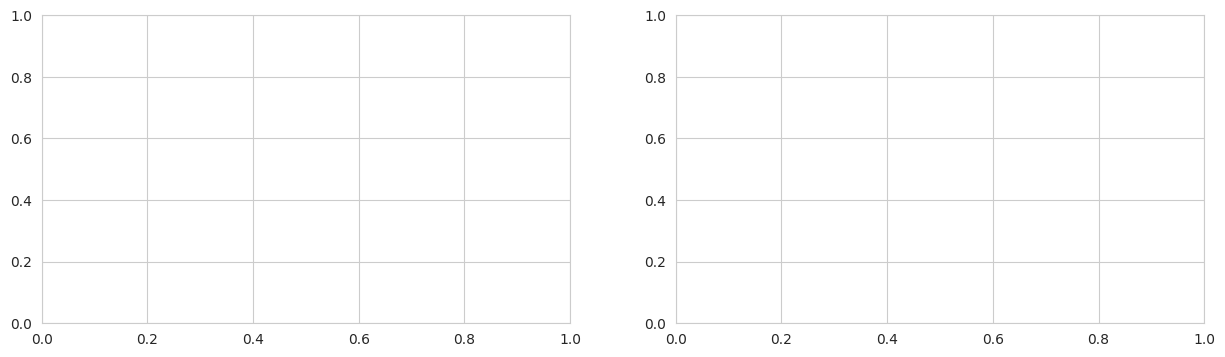

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics_tuned[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy Loss')
metrics_tuned[['accuracy', 'val_accuracy']].plot(ax=axes[0], title=f'Accuracy (Best: {metrics_tuned.val_accuracy.max():.2%})')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
for ax in axes:
    ax.axvline(10, ls='--', lw=1, c='k')
    ax.legend(['Training', 'Validation', 'Start Fine Tuning'])
    ax.set_xlabel('Epoch')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'transfer_learning');

## Evaluation and prediction

In [33]:
loss, accuracy = transfer_model.evaluate(validation_generator_cat)
print('Test accuracy :', accuracy)

8/8 [==============================] - 1s 126ms/step - loss: 0.0853 - accuracy: 0.9684
Test accuracy : 0.9683794379234314


In [34]:
# Retrieve a batch of images from the test set
image_batch, label_batch = validation_generator_cat.as_numpy_iterator().next()
predictions = transfer_model.predict_on_batch(image_batch).flatten()
class_names = ('Healthy','Salmonella')

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(class_names[predictions[i]])
  plt.axis("off")

AttributeError: 'DirectoryIterator' object has no attribute 'as_numpy_iterator'